In [1]:
# (C) Copyright IBM Corp. 2019, 2020, 2021, 2022.

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#           http://www.apache.org/licenses/LICENSE-2.0

#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [14]:
from simulai.file import SPFile
from simulai.optimization import Optimizer
from simulai.residuals import SymbolicOperator
from simulai.metrics import L2Norm
from simulai.templates import NetworkTemplate

#### Basic configuration.

In [4]:
save_path = './'
model_name = 'pendulum_deeponet'

#### The system of ODEs we aim at solving.
#### Damped Gravitational Pendulum:
$$
    \frac{d\,s_1}{d\,t} = s_2
$$
$$
    \frac{d\,s_2}{d\,t} = \frac{-b\,s_2}{m} - \frac{g\,sin(s_1)}{L}
$$


In [5]:
from scipy.integrate import odeint
import torch

#### Pendulum numerical solver.

In [6]:
class Pendulum:
    def __init__(self, rho: float = None, b: float = None, m: float = None) -> None:
        self.rho = rho
        self.b = b
        self.m = m

    def eval(self, state: np.ndarray = None, t: float = None) -> np.ndarray:
        x = state[0]
        y = state[1]

        x_residual = y
        y_residual = -self.b * y / self.m - self.rho * np.sin(x)

        return np.array([x_residual, y_residual])

    def run(self, initial_state, t):
        solution = odeint(self.eval, initial_state, t)

        return np.vstack(solution)

#### Pendulum DeepONet solver.

In [7]:
def deeponet_extrapolator(initial_state:np.ndarray=None,
                          time:np.ndarray=None,
                          net:NetworkTemplate=None) -> np.ndarray:
    
    branch_input_test = np.tile(initial_state[None, :], (Q, 1))
    trunk_input_test = time[:, None]

    eval_list = list()

    for i in range(0, n_times):
        branch_input_test = np.tile(initial_state[None, :], (Q, 1))

        approximated_data = net.eval(
            trunk_data=trunk_input_test, branch_data=branch_input_test
        )
        initial_state = approximated_data[-1]

        eval_list.append(approximated_data)

    evaluation = np.vstack(eval_list)
    time = np.linspace(0, n_times, evaluation.shape[0])

    return evaluation, time

#### Preparing evaluation domains.

In [8]:
Q = 1000
N = 100
dt = 1 / Q

t = np.arange(0, 100, dt)

initial_state_0 = np.array([1, 1])

s_intv = np.stack([[-1, -1], [1, 1]], axis=0)
U_s = np.random.uniform(low=s_intv[0], high=s_intv[1], size=(N, 2))
U_s = np.vstack([U_s, np.array([[1, 1]])])

#### Instantiating solver.

In [9]:
solver = Pendulum(rho=9.81, m=1, b=0.05)

#### Restoring DeepONet from disk.

In [10]:
saver = SPFile(compact=False)
pendulum_net = saver.read(model_path=os.path.join(save_path, model_name), device='cpu')

Summary of the network properties:
Linear operations layers:

[ Linear(in_features=1, out_features=100, bias=True),
  Linear(in_features=100, out_features=100, bias=True),
  Linear(in_features=100, out_features=100, bias=True),
  Linear(in_features=100, out_features=100, bias=True),
  Linear(in_features=100, out_features=100, bias=True),
  Linear(in_features=100, out_features=100, bias=True),
  Linear(in_features=100, out_features=100, bias=True),
  Linear(in_features=100, out_features=200, bias=True)]


Activations layers:

['tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'identity']


Initializations at each layer:

['xavier', 'xavier', 'xavier', 'xavier', 'xavier', 'xavier', 'xavier', 'xavier']
Summary of the network properties:
Linear operations layers:

[ Linear(in_features=2, out_features=100, bias=True),
  Linear(in_features=100, out_features=100, bias=True),
  Linear(in_features=100, out_features=100, bias=True),
  Linear(in_features=100, out_features=100, bias=True),
 

#### Getting the number of parameters for the model.

In [11]:
pendulum_net.n_parameters

160300

#### Extrapolating and evaluating error

In [12]:
exact_solutions = list()
approximated_solutions = list()
s1_errors = list()
s2_errors = list()

for j in range(N + 1):
    
    exact_data = solver.run(U_s[j], t)

    initial_state_test = U_s[j]

    n_outputs = 2
    n_times = 100

    evaluation, time = deeponet_extrapolator(initial_state=initial_state_test,
                                             time=np.linspace(0, 1, Q),
                                             net = pendulum_net)
    l2_norm = L2Norm()

    error_s1 = 100 * l2_norm(
        data=evaluation[:, 0], reference_data=exact_data[:, 0], relative_norm=True
    )
    error_s2 = 100 * l2_norm(
        data=evaluation[:, 1], reference_data=exact_data[:, 1], relative_norm=True
    )

    s1_errors.append(error_s1)
    s2_errors.append(error_s2)
    
    exact_solutions.append(exact_data)
    approximated_solutions.append(evaluation)

#### Plotting.



Case 0:
State 0, [0.0487741 0.9424491].
Approximation errors, s1: 5.0872335847500425 %, s2: 5.113031404880389 




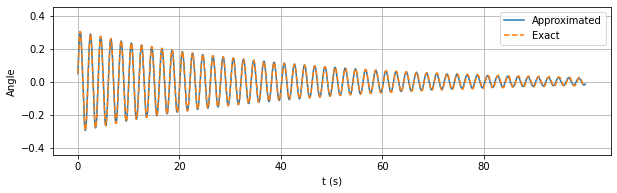

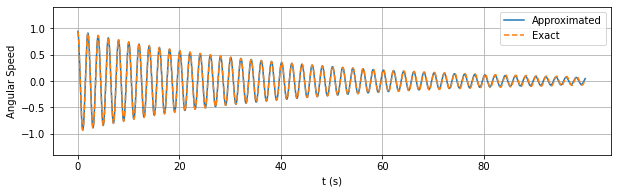



Case 10:
State 10, [-0.06388214  0.36861449].
Approximation errors, s1: 13.460132507368524 %, s2: 13.372921718701159 




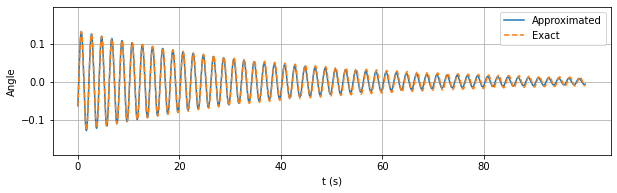

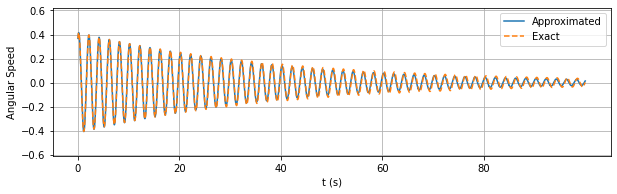



Case 20:
State 20, [0.8040672  0.90612333].
Approximation errors, s1: 1.2368141225690632 %, s2: 1.285968195537309 




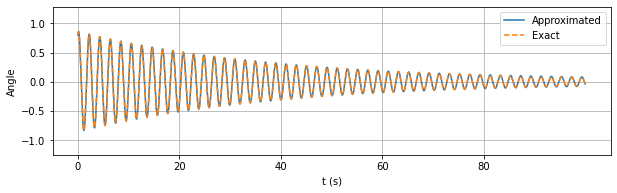

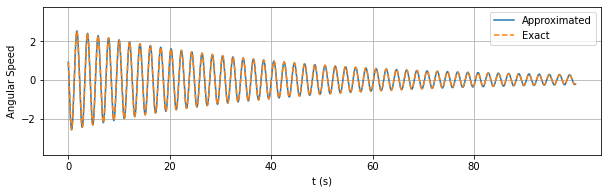



Case 30:
State 30, [-0.00906241  0.75592963].
Approximation errors, s1: 7.0013383848965285 %, s2: 7.011468161993712 




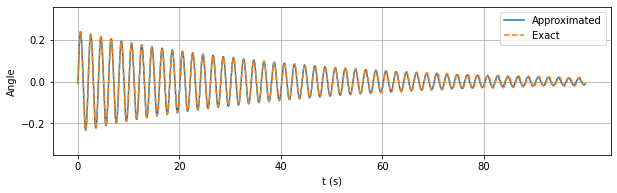

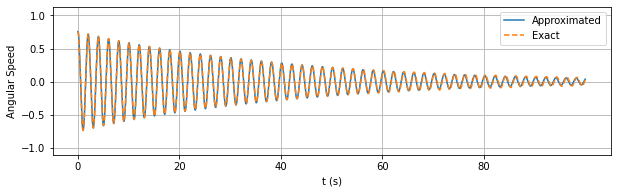



Case 40:
State 40, [ 0.20074962 -0.64054858].
Approximation errors, s1: 4.5481624342464055 %, s2: 4.4818681754892715 




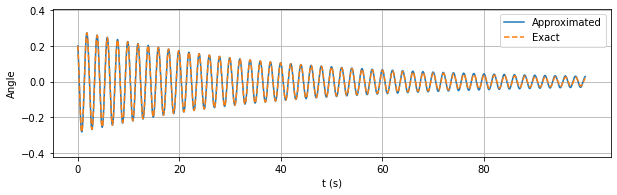

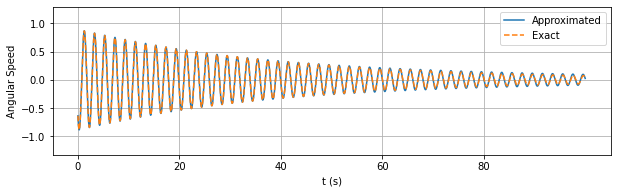



Case 50:
State 50, [-0.22437942 -0.5815888 ].
Approximation errors, s1: 9.59425000054059 %, s2: 9.683571036016849 




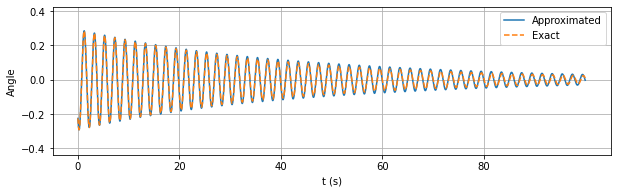

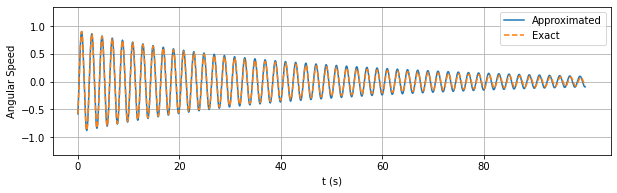



Case 60:
State 60, [ 0.15269957 -0.77988503].
Approximation errors, s1: 3.0200660387652665 %, s2: 2.966024861636813 




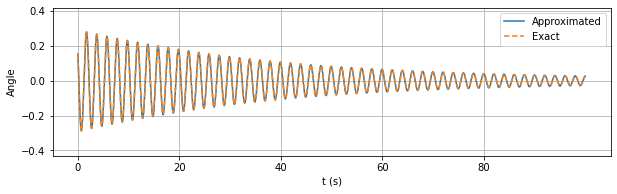

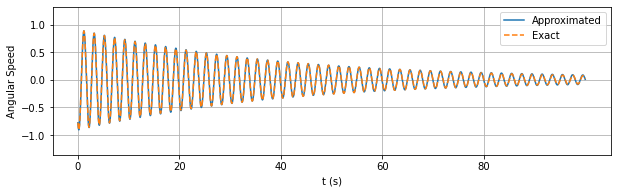



Case 70:
State 70, [-0.16628633  0.92521762].
Approximation errors, s1: 3.7097269926452925 %, s2: 3.625104074035458 




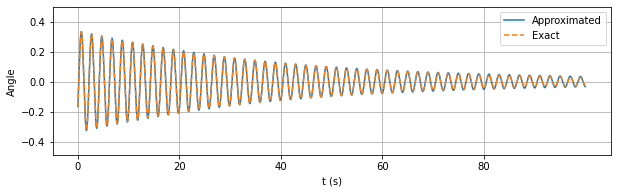

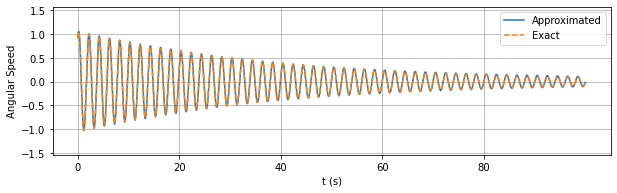



Case 80:
State 80, [0.605502   0.78116263].
Approximation errors, s1: 1.913745869900483 %, s2: 1.904841314865893 




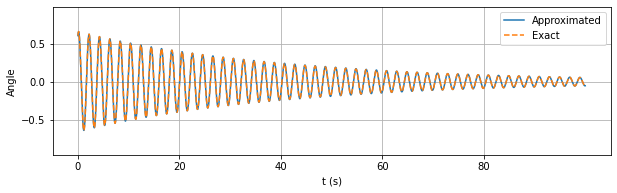

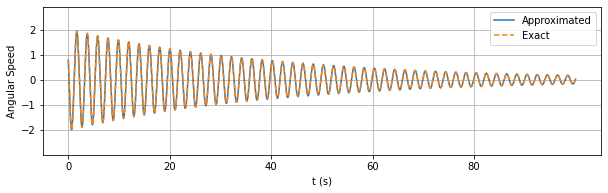



Case 90:
State 90, [-0.24206572 -0.92557313].
Approximation errors, s1: 5.1671506199245725 %, s2: 5.243515836513842 




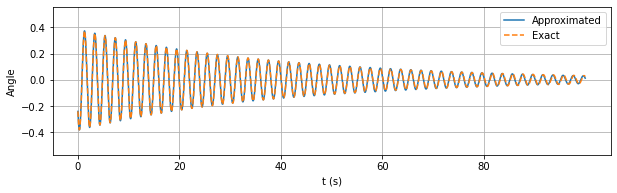

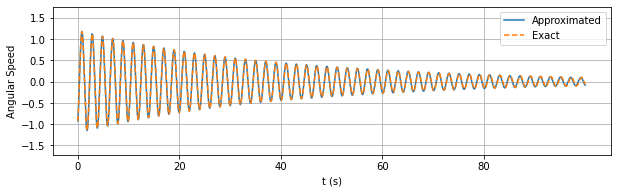



Case 100:
State 100, [1. 1.].
Approximation errors, s1: 0.4532841411674619 %, s2: 0.45491425357665355 




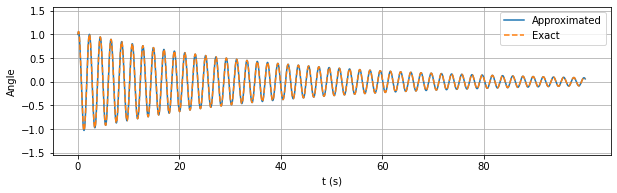

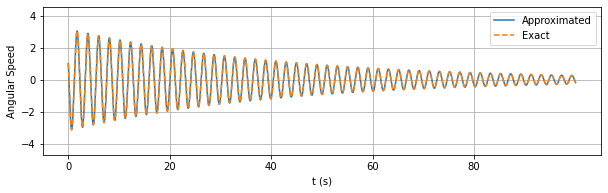

In [13]:
for j in range(N+1):
    
    if j % 10 == 0:
        
        print("\n")
        print(f"Case {j}:")
        print(f"State {j}, {U_s[j]}.")
        print(f"Approximation errors, s1: {s1_errors[j]} %, s2: {s2_errors[j]} ")
        print("\n")
        
        fig = plt.figure(figsize=(10, 6))
        ax1 = plt.subplot(211)
        
        ax1.plot(time, approximated_solutions[j][:, 0], label="Approximated")
        ax1.plot(time, exact_solutions[j][:, 0], label="Exact", ls="--")
        plt.xlabel("t (s)")
        plt.ylabel("Angle")

        plt.xticks(np.arange(0, 100, 20))
        plt.legend()
        plt.ylim(1.5 * exact_solutions[j][:, 0].min(), 1.5 * exact_solutions[j][:, 0].max())
        plt.savefig(f"{model_name}_s1_time_int_{j}.png")
        plt.grid(True)
        plt.show()
        plt.close()
        
        fig = plt.figure(figsize=(10, 6))
        ax2 = plt.subplot(212)
              
        ax2.plot(time, approximated_solutions[j][:, 1], label="Approximated")
        ax2.plot(time, exact_solutions[j][:, 1], label="Exact", ls="--")
        plt.xlabel("t (s)")
        plt.ylabel("Angular Speed")

        plt.xticks(np.arange(0, 100, 20))
        plt.legend()
        plt.ylim(1.5 * exact_solutions[j][:, 1].min(), 1.5 * exact_solutions[j][:, 1].max())
        plt.savefig(f"{model_name}_s2_time_int_{j}.png")
        plt.grid(True)
        plt.show()
        plt.close()